In [1]:
%matplotlib inline

In [2]:
from __future__ import division 

import os
import errno
import glob
# import ConfigParser #  python2

import configparser

import numpy as np
import pylab as plt

import astra

import logging
import logging.handlers
import json

In [3]:
astra.__version__

'1.8'

In [4]:
logging.getLogger('').setLevel(logging.ERROR)

In [5]:
def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  # Python >2.5
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

In [6]:
def log_progress(sequence, every=None, size=None):
    from ipywidgets import IntProgress, HTML, VBox
    from IPython.display import display

    is_iterator = False
    if size is None:
        try:
            size = len(sequence)
        except TypeError:
            is_iterator = True
    if size is not None:
        if every is None:
            if size <= 200:
                every = 1
            else:
                every = size / 200     # every 0.5%
    else:
        assert every is not None, 'sequence is iterator, set every'

    if is_iterator:
        progress = IntProgress(min=0, max=1, value=1)
        progress.bar_style = 'info'
    else:
        progress = IntProgress(min=0, max=size, value=0)
    label = HTML()
    box = VBox(children=[label, progress])
    display(box)

    index = 0
    try:
        for index, record in enumerate(sequence, 1):
            if index == 1 or index % every == 0:
                if is_iterator:
                    label.value = '{index} / ?'.format(index=index)
                else:
                    progress.value = index
                    label.value = u'{index} / {size}'.format(
                        index=index,
                        size=size
                    )
            yield record
    except:
        progress.bar_style = 'danger'
        raise
    else:
        progress.bar_style = 'success'
        progress.value = index
        label.value = unicode(index or '?')

In [7]:
def read_config(config_path):
    def as_dict(config):
        d = dict(config._sections)
        for k in d:
            d[k] = dict(config._defaults, **d[k])
            d[k].pop('__name__', None)
        return d
    
    config = ConfigParser.RawConfigParser()
    config.optionxform = str
    config.read(config_path)
    res = as_dict(config)
    return res

In [8]:
# Data directory
data_root = '/diskmnt/a/makov/yaivan/MMC_1/'
# data_root = '/media/makov/buext4/yaivan/MMC_1'
# nrecon_folder = os.path.join(data_root,'_tmp','nrecon', 'bh_92_rc_20')
nrecon_root_folder = os.path.join(data_root,'_tmp','nrecon')
astra_root_folder = os.path.join(data_root,'_tmp','astra')
mkdir_p(astra_root_folder)

LOG_FILENAME = os.path.join(astra_root_folder, 'astra_rec.out')

my_logger = logging.getLogger('')
my_logger.setLevel(logging.DEBUG)
handler = logging.handlers.RotatingFileHandler(
    LOG_FILENAME,  maxBytes=1e5, backupCount=5)
formatter = logging.Formatter('%(asctime)-15s %(levelname)-8s %(message)s')
handler.setFormatter(formatter)

my_logger.addHandler(handler)

In [9]:
nrecon_folders = glob.glob(os.path.join(nrecon_root_folder, '*'))
nrecon_folders = [nf for nf in nrecon_folders if os.path.isdir(nf)]
print len(nrecon_folders)

160


In [10]:
def build_reconstruction_geomety(detector_size, angles):
    
    # proj_geom = astra.create_proj_geom('parallel', 1.0, detector_size, angles)
    
    #Object to Source (mm) = 56.135
    #Camera to Source (mm) = 225.082
    
    # All distances in [pixels]
    pixel_size = 2.82473e-3
    os_distance = 56.135/pixel_size
    ds_distance = 225.082/pixel_size
    
    proj_geom = astra.create_proj_geom('fanflat', ds_distance/os_distance, detector_size, angles,
                                       os_distance, (ds_distance-os_distance))
    return proj_geom

In [72]:
def astra_tomo2d_fanflat_fbp(sinogram, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size # size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('FBP_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
    cfg['option']['ShortScan'] = True
#     cfg['option']['MinConstraint'] = 0
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id,  1)

    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def astra_tomo2d_fanflat_sirt(sinogram, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size # size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('SIRT_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
#     cfg['option']['MinConstraint'] = 0
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id,  200)

    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def astra_tomo2d_fanflat_sart(sinogram, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size # size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('SART_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
    cfg['option']['MinConstraint'] = 0
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id,  1000)

    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

# Define the plugin class (has to subclass astra.plugin.base)
# Note that usually, these will be defined in a separate package/module
class SIRTPlugin(astra.plugin.base):
    """Example of an ASTRA plugin class, implementing a simple 2D SIRT algorithm.

    Options:

    'rel_factor': relaxation factor (optional)
    """

    # The astra_name variable defines the name to use to
    # call the plugin from ASTRA
    astra_name = "SIRT-PLUGIN"

    def initialize(self,cfg, rel_factor = 1):
        self.W = astra.OpTomo(cfg['ProjectorId'])
        self.vid = cfg['ReconstructionDataId']
        self.sid = cfg['ProjectionDataId']
        self.rel = rel_factor

    def run(self, its):
        v = astra.data2d.get_shared(self.vid)
        s = astra.data2d.get_shared(self.sid)
        print s.shape
        W = self.W
        for i in range(its):
            v[:] += self.rel*(W.T*(s - (W*v).reshape(s.shape))).reshape(v.shape)/s.size
            
# from plugin import SIRTPlugin            
def astra_tomo2d_fanflat_plugin(sinogram, angles):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size # size of reconstruction region
    
    vol_geom = astra.create_vol_geom(rec_size, rec_size)
    proj_geom = build_reconstruction_geomety(detector_size, angles)
    proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)
    
    astra.plugin.register(SIRTPlugin)
    print astra.plugin.get_registered()
    
    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('SIRT-PLUGIN')
    cfg['ProjectorId'] = proj_id
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
    cfg['option']['rel_factor'] = 1.5
#     cfg['option']['MinConstraint'] = 0
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id,  10)

    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def create_sinogram(data, angles):  
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = data.shape[1]

    rec_size = detector_size # size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    proj_id = astra.create_projector('cuda',proj_geom,vol_geom)
    
    W = astra.OpTomo(proj_id)
    P = data
    sinogram = W * P
    sinogram = sinogram.reshape([len(angles), detector_size])
    return np.rot90(sinogram,3)

def get_reconstruction(sinogram, reconstruction_function, min_level=None):
    angles = np.arange(sinogram.shape[0])*0.1#-11.493867*2
    angles = angles.astype('float64')/180.*np.pi
    if min_level is None:
        astra_rec, proj_geom, cfg = reconstruction_function(np.flipud(sinogram), angles)
    else:
        astra_rec, proj_geom, cfg = reconstruction_function(np.flipud(sinogram), angles, min_level)
    logging.info('Projection geometry: {}'.format(proj_geom))
    logging.info('Reconstruction config: {}'.format(cfg))
    astra_rec = np.flipud(astra_rec)
    return astra_rec

def get_reconstruction_fbp(sinogram):
    return get_reconstruction(sinogram, astra_tomo2d_fanflat_fbp)

def get_reconstruction_sirt(sinogram):
    return get_reconstruction(sinogram, astra_tomo2d_fanflat_sirt)

def get_reconstruction_sart(sinogram):
    return get_reconstruction(sinogram, astra_tomo2d_fanflat_sart)

def get_reconstruction_plugin(sinogram):
    return get_reconstruction(sinogram, astra_tomo2d_fanflat_plugin)

In [64]:
# for nrecon_folder in log_progress(nrecon_folders):
#     data_file = os.path.join(nrecon_folder, 'MMC1_2.82um__sino0960.tif')
    
#     logging.info('Sinogram file: {}'.format(data_file))
#     sinogram = plt.imread(data_file)
#     logging.info('Sinogram angles, length: {}'.format(sinogram.shape))
    
#     nrecon_config_file = os.path.join(nrecon_folder, 'MMC1_2.82um__rec.log')
#     nrecon_config = read_config(nrecon_config_file)
    
#     rec_sart = get_reconstruction_sart(sinogram)
    
#     output_folder = os.path.join(astra_root_folder, nrecon_folder[len(nrecon_root_folder)+1:])
#     mkdir_p(output_folder)
#     astra_sart_file = os.path.join(output_folder, 'MMC1_2.82um__rec0960_astra_sart.png')
    
    
#     logging.info('Output file: {}'.format(astra_sart_file))
#     plt.imsave(astra_sart_file, rec_sart, cmap = plt.cm.gray)
    
#     data_config = os.path.join(output_folder, 'MMC1_2.82um__rec.log')
#     logging.info('Output config file: {}'.format(data_config))
    
#     config = ConfigParser.RawConfigParser()
#     config.optionxform = str
#     config.add_section('Reconstruction')
#     config.set('Reconstruction', 'Minimum for CS to Image Conversion', rec_sart.min())
#     config.set('Reconstruction', 'Maximum for CS to Image Conversion', rec_sart.max())
    
#     bh = nrecon_config['Reconstruction']['Beam Hardening Correction (%)']   
#     rc = nrecon_config['Reconstruction']['Ring Artifact Correction']
    
#     config.set('Reconstruction', 'Beam Hardening Correction (%)', bh)
#     config.set('Reconstruction', 'Ring Artifact Correction', rc)
    
#     with open(data_config, 'wb') as configfile:
#         config.write(configfile)
# #     # sinogram = sinogram[-1800:] 
# #     nrecon_rec_file = os.path.join(nrecon_folder,'MMC1_2.82um__rec0960.png')
# #     nrecon_rec = plt.imread(nrecon_rec_file)[...,0]

In [65]:
nrecon_folder = [d for d in nrecon_folders if 'bh_92_rc_20' in d][0]
nrecon_rec = plt.imread(os.path.join(nrecon_folder, 'MMC1_2.82um__rec0960.png'))[...,0]
nrecon_rec = nrecon_rec*(0.52+0.18)-0.18
print nrecon_folder

/diskmnt/a/makov/yaivan/MMC_1/_tmp/nrecon/bh_92_rc_20


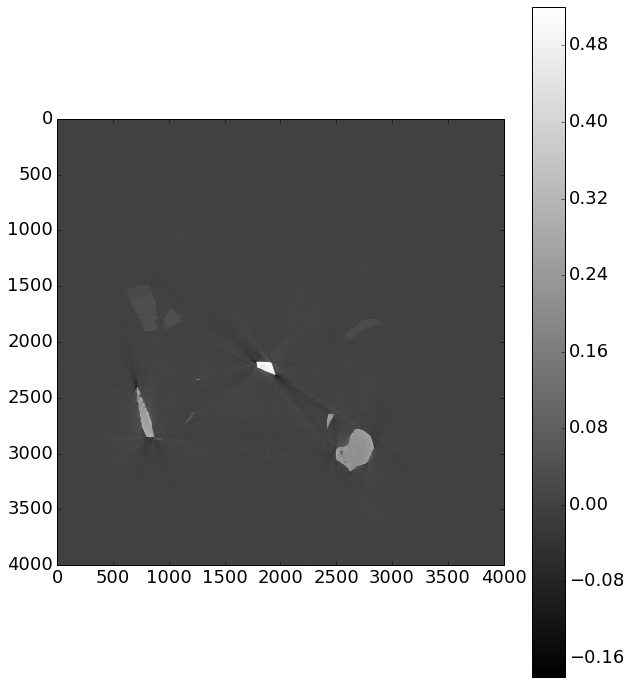

In [66]:
import matplotlib
font = {'size'   : 18}
matplotlib.rc('font', **font)

plt.figure(figsize=(10,12))
plt.imshow(nrecon_rec, cmap=plt.cm.gray)
plt.colorbar()
# plt.colorbar(orientation='horizontal')

In [67]:
# buzmakov
from numba import jit
import logging
from scipy import ndimage
import skimage.io

def calculate_background(data, zeros_mask):   
    labeled_mask, num_features = ndimage.measurements.label(zeros_mask)
    logging.info('Found regions: {}'.format(num_features-1))
    sigma = []
    for nf in range(num_features):
        if nf == 0 :
            continue
        
        data_constant = data[labeled_mask==nf]
        s = np.std(data_constant)
        sigma.append(s)
        
    logging.info('STD for regions: {}'.format(sigma))
    std = np.mean(sigma)
    logging.info('Mean STD for regions: {}'.format(std))
    mean_value = data.mean()
    logging.info('Mean reconstructed value for all data: {}'.format(mean_value))
    res = std/mean_value
    logging.info('Normalized STD: {}'.format(res))
    return  res

#ingacheva
from scipy import misc
from scipy import ndimage

@jit
def base_value(distance_transform, original):
    delta = distance_transform.max() * 0.9
    threshold =  distance_transform.max() - delta
    xx = 1 * np.logical_and(distance_transform >= threshold, distance_transform > 0)
    summ = xx.sum()
    base_v = original[distance_transform >= threshold].sum() / summ
    return base_v

@jit
def weighted_variance(mask, distance_transform, original):
    base_v = base_value(distance_transform, original)
    weight = np.zeros_like(mask)
    weight[mask > 0.0] = np.sqrt(distance_transform[mask > 0.0])
    threshold = distance_transform.max() * 0.8
    xx = 1 * np.logical_and(distance_transform <= threshold, distance_transform > 0.0)
    orig = np.zeros_like(mask)
    orig = orig.astype('float64')
    orig[xx > 0.0] = original[xx > 0.0] - base_v
    res = weight[xx > 0.0] * np.power(orig[xx > 0.0], 2)
    result = np.sqrt(res.sum() / weight[xx > 0.0].sum())
    return result

@jit
def calck_square(mask, distance_transform, original):
    base_v = base_value(distance_transform, original)
    iter_max = int(distance_transform.max())
    sq = 0
    for i in range(1, iter_max):
        
        value = original[(distance_transform>=i)*(distance_transform< i+1)].sum()
        sq += np.abs(base_v - value)
    sq =  sq / (base_v * iter_max)
    return sq

@jit
def calculate_cupping(original, mask):
    mask[mask > 0.0] = 1.0
    labeled, nr_objects = ndimage.label(mask > 0.0)
#     ndimage.find_objects(labeled)
    logging.info('Number of objects is {}'.format(nr_objects))


    result = 0
    square = 0
    for i in range(1, nr_objects+1):
        mask[mask > 0.0] = 0.0
        mask[labeled == i] = 1.0
        
        
        sx = mask.sum(axis=0)
        sxx = np.argwhere(sx>0)
        x_min = sxx.min()
        x_max = sxx.max()
        
        sy = mask.sum(axis=1)
        syy = np.argwhere(sy>0)
        y_min = syy.min()
        y_max = syy.max()
        
        dist = ndimage.distance_transform_edt(mask[y_min:y_max, x_min:x_max])
        

        #res = weighted_variance(mask, dist, original)
        #result += res
        #data['weighted_variance'] = res

        sq = calck_square(mask[y_min:y_max, x_min:x_max],
                          dist,
                          original[y_min:y_max, x_min:x_max])
        square += sq
        logging.info("square {} of the object {}".format(sq, i))

    #result = result / nr_objects
    #print 'mean weighted variance ', result

    square = square / nr_objects
    return square

mask_background = skimage.io.imread(
    '/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_MASK_ZEROS_CONERS.png')[...,0]
mask_cup = skimage.io.imread(
    '/diskmnt/a/makov/yaivan/MMC_1/_tmp/binary_masks/MMC1_2.82um__rec0960_Mask_objects.png')[...,0]

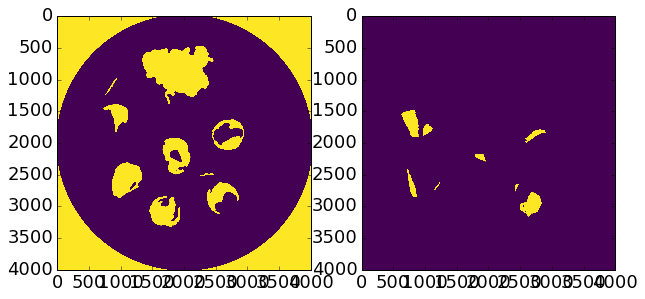

In [68]:
plt.figure(figsize=(10,5))
plt.subplot(121)
plt.imshow(mask_background, cmap=plt.cm.viridis)
plt.subplot(122)
plt.imshow(mask_cup, cmap=plt.cm.viridis)

In [69]:
data_file = os.path.join(nrecon_folder, 'MMC1_2.82um__sino0960.tif')
sinogram = plt.imread(data_file)

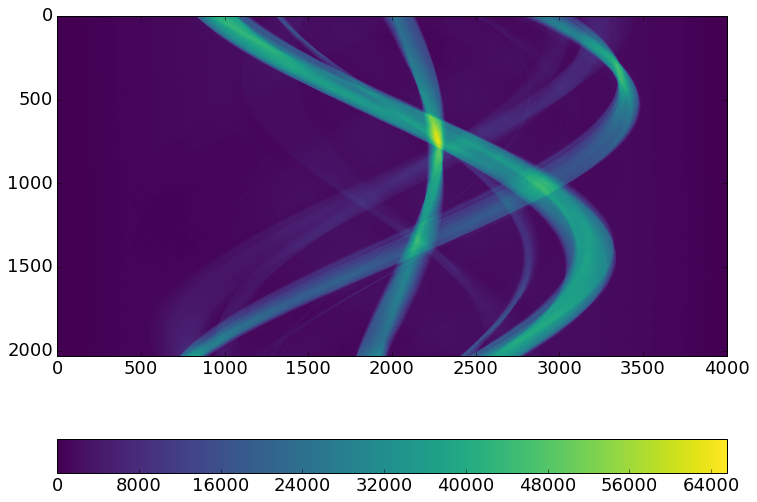

In [18]:
plt.figure(figsize=(12,10))
plt.imshow(sinogram, cmap=plt.cm.viridis)
plt.colorbar(orientation='horizontal')

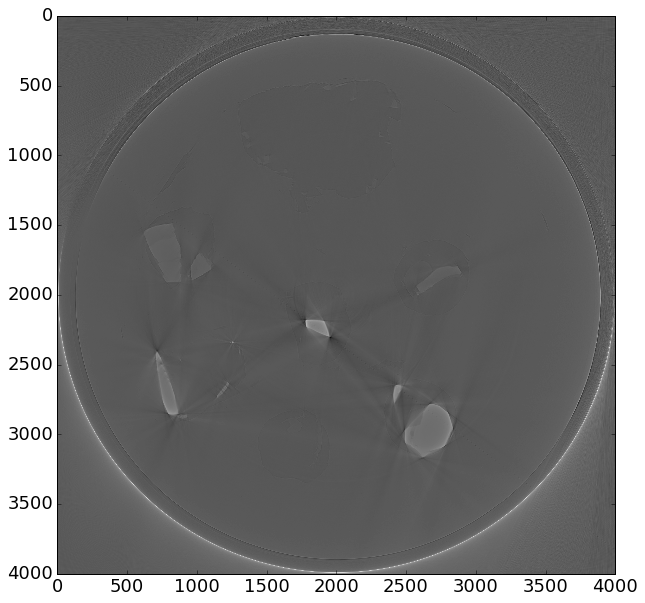

In [90]:
r=get_reconstruction_fbp(np.log(sinogram+2))
plt.figure(figsize=(12,10))
plt.imshow(r, cmap=plt.cm.gray)
# plt.colorbar(orientation='horizontal')

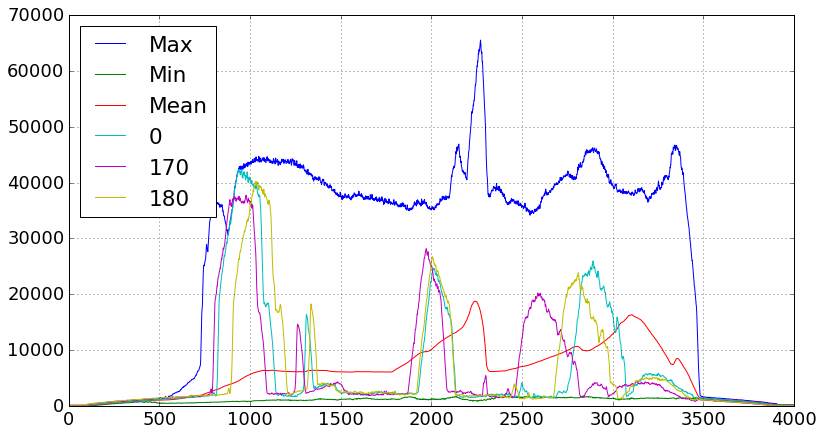

In [53]:
plt.figure(figsize=(13,7))
plt.plot(sinogram.max(axis=0), label='Max')
plt.hold(True)
plt.plot(sinogram.min(axis=0), label='Min')
plt.plot(sinogram.mean(axis=0), label='Mean')
plt.plot(sinogram[0], label='0')
plt.plot(sinogram[1700,::-1], label='170')
plt.plot(sinogram[1800,::-1], label='180')
plt.legend(loc=0)
plt.grid(True)
plt.show()

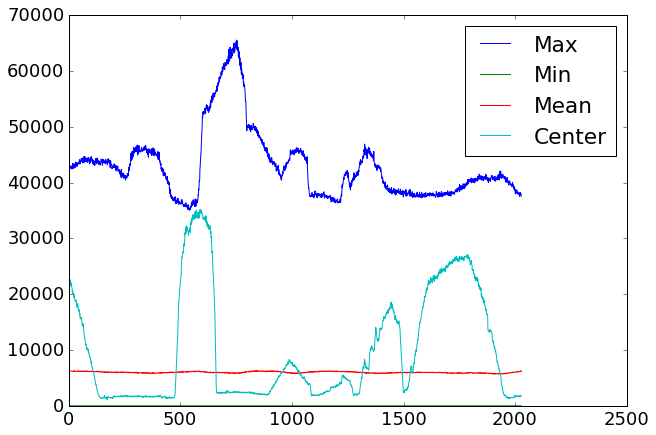

In [48]:
plt.figure(figsize=(10,7))
plt.plot(sinogram.max(axis=1), label='Max')
plt.hold(True)
plt.plot(sinogram.min(axis=1), label='Min')
plt.plot(sinogram.mean(axis=1), label='Mean')
plt.plot(sinogram[:,int(sinogram.shape[1]/2)], label='Center')
plt.legend(loc=0)
plt.show()

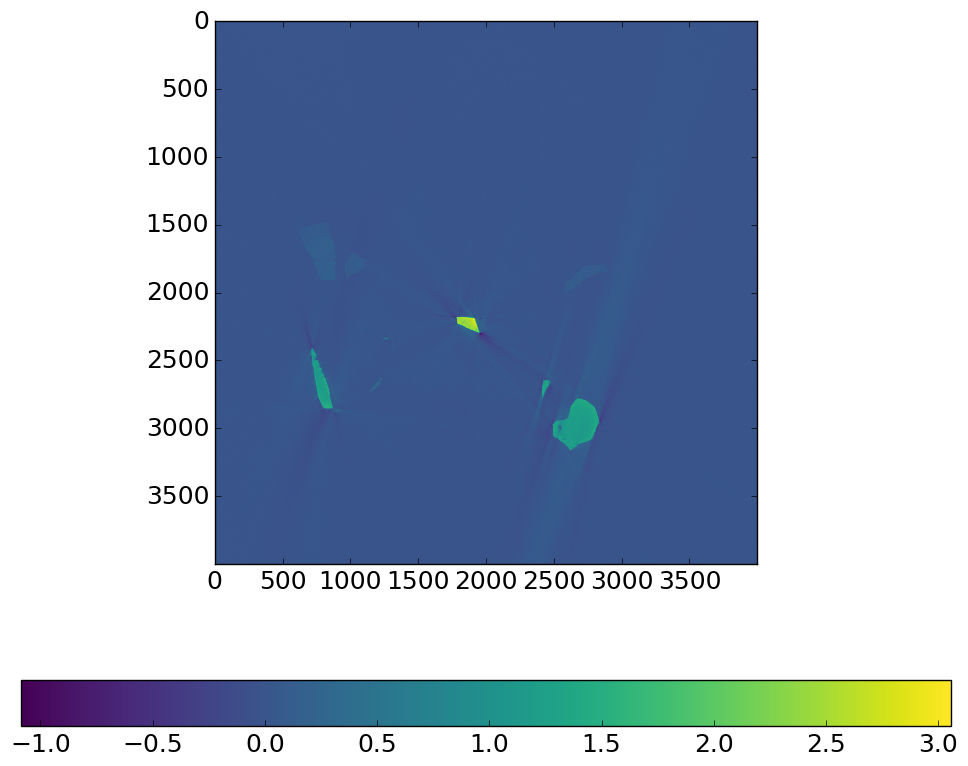

In [20]:
plt.figure(figsize=(12,10))
plt.imshow(r, cmap=plt.cm.viridis)
plt.colorbar(orientation='horizontal')

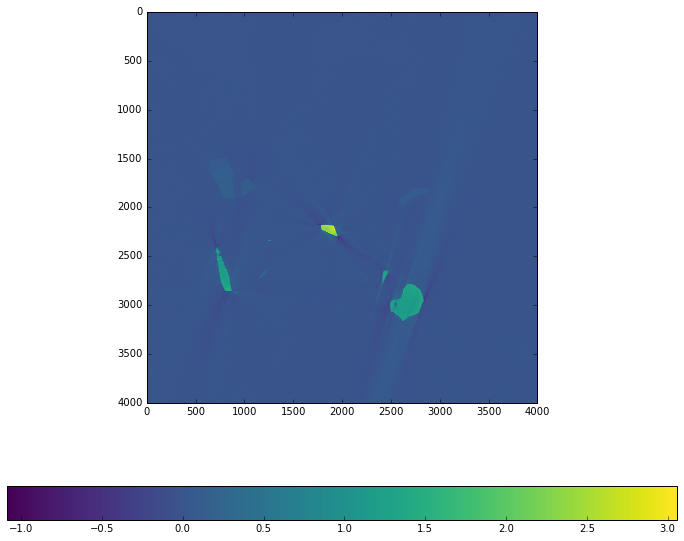

In [16]:
plt.figure(figsize=(12,10))
plt.imshow(r, cmap=plt.cm.viridis)
plt.colorbar(orientation='horizontal')

In [ ]:
rois = []
rois.append(np.ix_(np.r_[2100:2350],np.r_[1700:2000]))
rois.append(np.ix_(np.r_[2750:3200],np.r_[2350:2900]))
rois.append(np.ix_(np.r_[2300:2380],np.r_[1200:1300]))
rois.append(np.ix_(np.r_[2600:2750],np.r_[1100:1300]))
rois.append(np.ix_(np.r_[2400:2900],np.r_[600:1000]))
rois.append(np.ix_(np.r_[2700:3500],np.r_[1300:2100]))
rois.append(np.ix_(np.r_[1450:2000],np.r_[600:1150]))
rois.append(np.ix_(np.r_[1750:2050],np.r_[2500:2930]))

In [ ]:
def astra_my(sinogram, angles, min_level=0):
    angles = angles.astype('float64') # hack for astra stability, may be removed in future releases
    detector_size = sinogram.shape[1]
    

    rec_size = detector_size # size of reconstruction region
    vol_geom = astra.create_vol_geom(rec_size, rec_size)

    proj_geom = build_reconstruction_geomety(detector_size, angles)
    
    sinogram_id = astra.data2d.create('-sino', proj_geom, data=sinogram)
    # Create a data object for the reconstruction
    rec_id = astra.data2d.create('-vol', vol_geom)

    # Set up the parameters for a reconstruction algorithm using the GPU
    cfg = astra.astra_dict('SART_CUDA')
    cfg['ReconstructionDataId'] = rec_id
    cfg['ProjectionDataId'] = sinogram_id
    cfg['option'] = {}
    cfg['option']['MinConstraint'] = min_level
    # cfg['option']['MaxConstraint'] = 5

    # Available algorithms:
    # SIRT_CUDA, SART_CUDA, EM_CUDA, FBP_CUDA (see the FBP sample)

    # Create the algorithm object from the configuration structure
    alg_id = astra.algorithm.create(cfg)

    # Run 150 iterations of the algorithm
    astra.algorithm.run(alg_id,  10000)

    # Get the result
    rec = astra.data2d.get(rec_id)

    # Clean up. Note that GPU memory is tied up in the algorithm object,
    # and main RAM in the data objects.
    astra.algorithm.delete(alg_id)
    astra.data2d.delete(rec_id)
    astra.data2d.delete(sinogram_id)
    astra.clear()
    return rec, proj_geom, cfg

def get_reconstruction_my(sinogram, min_level):
    return get_reconstruction(sinogram, astra_my, min_level)

In [ ]:
# rec_my = rec_fbp
# plt.figure(figsize=(15,15))
# plt.imshow(rec_my/(rec_my.max()-rec_my.min())-nrecon_rec/(nrecon_rec.max()-nrecon_rec.min()), cmap=plt.cm.gray)
# plt.title('My')
# plt.show()
logging.getLogger('').setLevel(logging.ERROR)
rec_fbp =  get_reconstruction_fbp(sinogram[-1800:])

for min_level in log_progress(np.arange(-3,-1,1)):
    print 'Min_level = {}'.format(min_level)
    rec_my = get_reconstruction_my(sinogram, min_level)
    

    artifact_my_bg = calculate_background(rec_my, mask_background)
    artifact_my_cup = calculate_cupping(rec_my, mask_cup)
    print 'My: bg:{}, cup:{}'.format(artifact_my_bg, artifact_my_cup)

    artifact_fbp_bg = calculate_background(rec_fbp, mask_background)
    artifact_fbp_cup = calculate_cupping(rec_fbp, mask_cup)
    print 'FBP: bg:{}, cup:{}'.format(artifact_fbp_bg, artifact_fbp_cup)

    artifact_nrecon_bg = calculate_background(nrecon_rec, mask_background)
    artifact_nrecon_cup = calculate_cupping(nrecon_rec, mask_cup)
    print 'NRecon: bg:{}, cup:{}'.format(artifact_nrecon_bg, artifact_nrecon_cup)

    for roi in rois:
        d_my = rec_my[roi]
        d_fbp = rec_fbp[roi]
        d_nrecon = nrecon_rec[roi]

        plt.figure(figsize=(15,15))

        plt.subplot(221)
        plt.imshow(d_my, cmap=plt.cm.gray, vmin=0)
        plt.title('My')

        plt.subplot(222)
        plt.imshow(d_fbp, cmap=plt.cm.gray, vmin=0)
        plt.title('FBP')

        plt.subplot(223)
        plt.imshow(d_nrecon, cmap=plt.cm.gray, vmin=0)
        plt.title('NRecon')

        plt.subplot(224)
        pos = int(d_my.shape[0]/2)
        d_my_1 = d_my[pos]
        d_my_1 = d_my_1/ (d_my_1.max()-d_my_1.min())

        d_fbp_1 = d_fbp[pos]
        d_fbp_1 = d_fbp_1/ (d_fbp_1.max()-d_fbp_1.min())

        d_nrecon_1 = d_nrecon[pos]
        d_nrecon_1 = d_nrecon_1/ (d_nrecon_1.max()-d_nrecon_1.min())


        plt.plot(d_my_1, label='my')
        plt.plot(d_fbp_1, label='FBP')
        plt.plot(d_nrecon_1, label='NRecon')
        plt.grid()
        plt.legend(loc=0)
        # plt.colorbar(orientation='horizontal')
        plt.show()
        
    plt.figure(figsize=(15,15))
    plt.imshow(rec_my, cmap=plt.cm.gray)
    plt.title('My')
    plt.show()
    
    plt.figure(figsize=(15,15))
    plt.imshow(nrecon_rec, cmap=plt.cm.gray)
    plt.title('NRecon')
    plt.show()
    

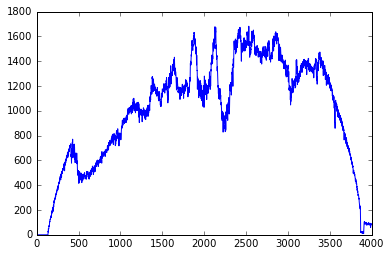

In [37]:
plt.plot(sinogram.min(axis=0))